In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import os
import time

import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

sys.path.append(os.path.join(os.environ['REPO_DIR'], 'utilities'))
from utilities2015 import *
from registration_utilities import *
from annotation_utilities import *
from metadata import *
from data_manager import *

/usr/local/lib/python2.7/dist-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


Setting environment for AWS compute node


No vtk


In [3]:
stack_fixed = 'RV13_64hrs'
stack_moving = 'atlasV5'

In [5]:
# warp_setting = 20
warp_setting = 16
# Adding surr is essential.

In [6]:
registration_settings = read_csv(REGISTRATION_SETTINGS_CSV, header=0, index_col=0)
registration_settings

,upstream_warp_id,transform_type,terminate_thresh,grad_computation_sample_number,grid_search_sample_number,std_tx_um,std_ty_um,std_tz_um,std_theta_xy_degree,surround_weight,regularization_weight,comment,max_iter_num
warp_id,,,,,,,,,,,,,
1,None,affine,0.000010,100000.0,1000.0,2000.0,2000.0,2000.0,30.0,0,NaN,NaN,NaN
2,1,rigid,0.000010,100000.0,10000.0,100.0,100.0,100.0,30.0,0,NaN,NaN,NaN
4,1,rigid,0.000001,100000.0,10000.0,100.0,100.0,100.0,10.0,0,0.000001,NaN,NaN
5,1,rigid,0.000001,100000.0,10000.0,100.0,100.0,100.0,30.0,inverse,0.000000,NaN,NaN
6,1,affine,0.000010,100000.0,10000.0,100.0,100.0,100.0,30.0,-0.5,0.000000,NaN,NaN
7,None,rigid,0.000001,100000.0,1000.0,50.0,50.0,50.0,10.0,0,NaN,NaN,NaN
8,None,rigid,0.000001,100000.0,10000.0,200.0,200.0,200.0,30.0,inverse,0.000000,align mid-sagittal planes,NaN
9,8,rigid,0.000001,100000.0,10000.0,2000.0,2000.0,2000.0,30.0,NaN,NaN,global registration given mid-sagittal planes ...,NaN
18,8,affine,0.000001,100000.0,10000.0,200.0,200.0,200.0,30.0,NaN,NaN,global registration given mid-sagittal planes ...,NaN


In [144]:
warp_properties = registration_settings.loc[warp_setting]
print warp_properties

upstream_warp_setting = warp_properties['upstream_warp_id']
if upstream_warp_setting == 'None':
    upstream_warp_setting = None
transform_type = warp_properties['transform_type']
terminate_thresh = warp_properties['terminate_thresh']
grad_computation_sample_number = int(warp_properties['grad_computation_sample_number'])
grid_search_sample_number = warp_properties['grid_search_sample_number']
std_tx_um = warp_properties['std_tx_um']
std_ty_um = warp_properties['std_ty_um']
std_tz_um = warp_properties['std_tz_um']
std_tx = std_tx_um/(XY_PIXEL_DISTANCE_LOSSLESS*32)
std_ty = std_ty_um/(XY_PIXEL_DISTANCE_LOSSLESS*32)
std_tz = std_tz_um/(XY_PIXEL_DISTANCE_LOSSLESS*32)
std_theta_xy = np.deg2rad(warp_properties['std_theta_xy_degree'])
print std_tx, std_ty, std_tz, std_theta_xy

surround_weight = warp_properties['surround_weight']
# surround_weight = np.nan
if isinstance(surround_weight, float) or isinstance(surround_weight, int):
    surround_weight = float(surround_weight)
    include_surround = surround_weight != 0 and not np.isnan(surround_weight)
elif isinstance(surround_weight, str):
    surround_weight = str(surround_weight)
    # Setting surround_weight as inverse is very important. Using -1 often gives false peaks.
    include_surround = True
print include_surround

upstream_warp_id                                  None
transform_type                                  affine
terminate_thresh                                 1e-05
grad_computation_sample_number                  100000
grid_search_sample_number                         1000
std_tx_um                                         2000
std_ty_um                                         2000
std_tz_um                                         2000
std_theta_xy_degree                                 30
surround_weight                                inverse
regularization_weight                              NaN
comment                           global reg with surr
max_iter_num                                       NaN
Name: 16, dtype: object
135.869565217 135.869565217 135.869565217 0.523598775598
True


In [145]:
MAX_ITER_NUM = 1000
HISTORY_LEN = 20
MAX_GRID_SEARCH_ITER_NUM = 30

lr1 = 10
lr2 = 0.1

In [146]:
volume_moving, structure_to_label_moving, label_to_structure_moving = \
DataManager.load_original_volume_all_known_structures(stack=stack_moving, sided=True, volume_type='score', 
                                                      include_surround=include_surround)
print volume_moving[1].shape

Prior structure/index map not found. Generating a new one.


(356, 427, 375)


Volume shape: (356, 427, 375)


In [147]:
volume_fixed, structure_to_label_fixed, label_to_structure_fixed = \
DataManager.load_original_volume_all_known_structures(stack=stack_fixed, sided=True, 
                                                      volume_type='annotationAsScore',
                                                     include_surround=include_surround)

print volume_fixed[1].shape

Prior structure/index map not found. Generating a new one.


rm -rf "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_10N_L.bp" && mkdir -p "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_10N_L.bp" "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_10N_L.bp"


File does not exist: /shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_10N_L.bp
Score volume for 10N_L does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_10N_L.bp'


rm -rf "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_10N_L_surround_200.bp" && mkdir -p "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_10N_L_surround_200.bp" "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_10N_L_surround_200.bp"


File does not exist: /shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_10N_L_surround_200.bp
Score volume for 10N_L_surround_200 does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_10N_L_surround_200.bp'


rm -rf "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_10N_R.bp" && mkdir -p "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_10N_R.bp" "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_10N_R.bp"


File does not exist: /shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_10N_R.bp
Score volume for 10N_R does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_10N_R.bp'


rm -rf "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_10N_R_surround_200.bp" && mkdir -p "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_10N_R_surround_200.bp" "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_10N_R_surround_200.bp"


File does not exist: /shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_10N_R_surround_200.bp
Score volume for 10N_R_surround_200 does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_10N_R_surround_200.bp'


rm -rf "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_12N.bp" && mkdir -p "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_12N.bp" "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_12N.bp"


File does not exist: /shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_12N.bp
Score volume for 12N does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_12N.bp'


rm -rf "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_12N_surround_200.bp" && mkdir -p "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_12N_surround_200.bp" "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_12N_surround_200.bp"


File does not exist: /shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_12N_surround_200.bp
Score volume for 12N_surround_200 does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_12N_surround_200.bp'


rm -rf "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_3N_L.bp" && mkdir -p "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_3N_L.bp" "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_3N_L.bp"


File does not exist: /shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_3N_L.bp
Score volume for 3N_L does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_3N_L.bp'


rm -rf "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_3N_L_surround_200.bp" && mkdir -p "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_3N_L_surround_200.bp" "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_3N_L_surround_200.bp"


File does not exist: /shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_3N_L_surround_200.bp
Score volume for 3N_L_surround_200 does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_3N_L_surround_200.bp'


rm -rf "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_3N_R.bp" && mkdir -p "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_3N_R.bp" "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_3N_R.bp"


File does not exist: /shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_3N_R.bp
Score volume for 3N_R does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_3N_R.bp'


rm -rf "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_3N_R_surround_200.bp" && mkdir -p "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_3N_R_surround_200.bp" "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_3N_R_surround_200.bp"


File does not exist: /shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_3N_R_surround_200.bp
Score volume for 3N_R_surround_200 does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_3N_R_surround_200.bp'


rm -rf "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_4N_L.bp" && mkdir -p "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_4N_L.bp" "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_4N_L.bp"


File does not exist: /shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_4N_L.bp
Score volume for 4N_L does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_4N_L.bp'


rm -rf "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_4N_L_surround_200.bp" && mkdir -p "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_4N_L_surround_200.bp" "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_4N_L_surround_200.bp"


File does not exist: /shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_4N_L_surround_200.bp
Score volume for 4N_L_surround_200 does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_4N_L_surround_200.bp'


rm -rf "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_4N_R.bp" && mkdir -p "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_4N_R.bp" "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_4N_R.bp"


File does not exist: /shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_4N_R.bp
Score volume for 4N_R does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_4N_R.bp'


rm -rf "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_4N_R_surround_200.bp" && mkdir -p "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_4N_R_surround_200.bp" "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_4N_R_surround_200.bp"


File does not exist: /shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_4N_R_surround_200.bp
Score volume for 4N_R_surround_200 does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_4N_R_surround_200.bp'


rm -rf "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_6N_L.bp" && mkdir -p "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_6N_L.bp" "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_6N_L.bp"


File does not exist: /shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_6N_L.bp
Score volume for 6N_L does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_6N_L.bp'


rm -rf "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_6N_L_surround_200.bp" && mkdir -p "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_6N_L_surround_200.bp" "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_6N_L_surround_200.bp"


File does not exist: /shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_6N_L_surround_200.bp
Score volume for 6N_L_surround_200 does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_6N_L_surround_200.bp'


rm -rf "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_6N_R.bp" && mkdir -p "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_6N_R.bp" "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_6N_R.bp"


File does not exist: /shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_6N_R.bp
Score volume for 6N_R does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_6N_R.bp'


rm -rf "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_6N_R_surround_200.bp" && mkdir -p "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_6N_R_surround_200.bp" "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_6N_R_surround_200.bp"


File does not exist: /shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_6N_R_surround_200.bp
Score volume for 6N_R_surround_200 does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_6N_R_surround_200.bp'


rm -rf "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_AP.bp" && mkdir -p "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_AP.bp" "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_AP.bp"


File does not exist: /shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_AP.bp
Score volume for AP does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_AP.bp'


rm -rf "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_AP_surround_200.bp" && mkdir -p "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_AP_surround_200.bp" "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_AP_surround_200.bp"


File does not exist: /shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_AP_surround_200.bp
Score volume for AP_surround_200 does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_AP_surround_200.bp'


rm -rf "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_Amb_R.bp" && mkdir -p "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_Amb_R.bp" "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_Amb_R.bp"


File does not exist: /shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_Amb_R.bp
Score volume for Amb_R does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_Amb_R.bp'


rm -rf "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_Amb_R_surround_200.bp" && mkdir -p "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_Amb_R_surround_200.bp" "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_Amb_R_surround_200.bp"


File does not exist: /shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_Amb_R_surround_200.bp
Score volume for Amb_R_surround_200 does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_Amb_R_surround_200.bp'


rm -rf "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_DC_L.bp" && mkdir -p "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_DC_L.bp" "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_DC_L.bp"


File does not exist: /shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_DC_L.bp
Score volume for DC_L does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_DC_L.bp'


rm -rf "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_DC_L_surround_200.bp" && mkdir -p "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_DC_L_surround_200.bp" "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_DC_L_surround_200.bp"


File does not exist: /shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_DC_L_surround_200.bp
Score volume for DC_L_surround_200 does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_DC_L_surround_200.bp'


rm -rf "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_DC_R.bp" && mkdir -p "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_DC_R.bp" "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_DC_R.bp"


File does not exist: /shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_DC_R.bp
Score volume for DC_R does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_DC_R.bp'


rm -rf "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_DC_R_surround_200.bp" && mkdir -p "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_DC_R_surround_200.bp" "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_DC_R_surround_200.bp"


File does not exist: /shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_DC_R_surround_200.bp
Score volume for DC_R_surround_200 does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_DC_R_surround_200.bp'


rm -rf "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_IC.bp" && mkdir -p "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_IC.bp" "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_IC.bp"


File does not exist: /shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_IC.bp
Score volume for IC does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_IC.bp'


rm -rf "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_IC_surround_200.bp" && mkdir -p "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_IC_surround_200.bp" "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_IC_surround_200.bp"


File does not exist: /shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_IC_surround_200.bp
Score volume for IC_surround_200 does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_IC_surround_200.bp'


rm -rf "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_LC_L.bp" && mkdir -p "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_LC_L.bp" "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_LC_L.bp"


File does not exist: /shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_LC_L.bp
Score volume for LC_L does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_LC_L.bp'


rm -rf "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_LC_L_surround_200.bp" && mkdir -p "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_LC_L_surround_200.bp" "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_LC_L_surround_200.bp"


File does not exist: /shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_LC_L_surround_200.bp
Score volume for LC_L_surround_200 does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_LC_L_surround_200.bp'


rm -rf "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_LC_R.bp" && mkdir -p "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_LC_R.bp" "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_LC_R.bp"


File does not exist: /shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_LC_R.bp
Score volume for LC_R does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_LC_R.bp'


rm -rf "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_LC_R_surround_200.bp" && mkdir -p "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_LC_R_surround_200.bp" "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_LC_R_surround_200.bp"


File does not exist: /shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_LC_R_surround_200.bp
Score volume for LC_R_surround_200 does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_LC_R_surround_200.bp'


rm -rf "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_PBG_L.bp" && mkdir -p "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_PBG_L.bp" "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_PBG_L.bp"


File does not exist: /shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_PBG_L.bp
Score volume for PBG_L does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_PBG_L.bp'


rm -rf "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_PBG_L_surround_200.bp" && mkdir -p "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_PBG_L_surround_200.bp" "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_PBG_L_surround_200.bp"


File does not exist: /shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_PBG_L_surround_200.bp
Score volume for PBG_L_surround_200 does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_PBG_L_surround_200.bp'


rm -rf "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_PBG_R.bp" && mkdir -p "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_PBG_R.bp" "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_PBG_R.bp"


File does not exist: /shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_PBG_R.bp
Score volume for PBG_R does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_PBG_R.bp'


rm -rf "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_PBG_R_surround_200.bp" && mkdir -p "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_PBG_R_surround_200.bp" "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_PBG_R_surround_200.bp"


File does not exist: /shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_PBG_R_surround_200.bp
Score volume for PBG_R_surround_200 does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_PBG_R_surround_200.bp'


rm -rf "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_Pn_L.bp" && mkdir -p "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_Pn_L.bp" "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_Pn_L.bp"


File does not exist: /shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_Pn_L.bp
Score volume for Pn_L does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_Pn_L.bp'


rm -rf "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_Pn_L_surround_200.bp" && mkdir -p "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_Pn_L_surround_200.bp" "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_Pn_L_surround_200.bp"


File does not exist: /shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_Pn_L_surround_200.bp
Score volume for Pn_L_surround_200 does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_Pn_L_surround_200.bp'


rm -rf "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_Pn_R.bp" && mkdir -p "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_Pn_R.bp" "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_Pn_R.bp"


File does not exist: /shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_Pn_R.bp
Score volume for Pn_R does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_Pn_R.bp'


rm -rf "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_Pn_R_surround_200.bp" && mkdir -p "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_Pn_R_surround_200.bp" "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_Pn_R_surround_200.bp"


File does not exist: /shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_Pn_R_surround_200.bp
Score volume for Pn_R_surround_200 does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_Pn_R_surround_200.bp'


rm -rf "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_RMC_L.bp" && mkdir -p "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_RMC_L.bp" "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_RMC_L.bp"


File does not exist: /shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_RMC_L.bp
Score volume for RMC_L does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_RMC_L.bp'


rm -rf "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_RMC_L_surround_200.bp" && mkdir -p "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_RMC_L_surround_200.bp" "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_RMC_L_surround_200.bp"


File does not exist: /shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_RMC_L_surround_200.bp
Score volume for RMC_L_surround_200 does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_RMC_L_surround_200.bp'


rm -rf "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_RMC_R.bp" && mkdir -p "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_RMC_R.bp" "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_RMC_R.bp"


File does not exist: /shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_RMC_R.bp
Score volume for RMC_R does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_RMC_R.bp'


rm -rf "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_RMC_R_surround_200.bp" && mkdir -p "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_RMC_R_surround_200.bp" "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_RMC_R_surround_200.bp"


File does not exist: /shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_RMC_R_surround_200.bp
Score volume for RMC_R_surround_200 does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_RMC_R_surround_200.bp'


rm -rf "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_RtTg.bp" && mkdir -p "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_RtTg.bp" "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_RtTg.bp"


File does not exist: /shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_RtTg.bp
Score volume for RtTg does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_RtTg.bp'


rm -rf "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_RtTg_surround_200.bp" && mkdir -p "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_RtTg_surround_200.bp" "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_RtTg_surround_200.bp"


File does not exist: /shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_RtTg_surround_200.bp
Score volume for RtTg_surround_200 does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_RtTg_surround_200.bp'


rm -rf "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_SC.bp" && mkdir -p "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_SC.bp" "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_SC.bp"


File does not exist: /shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_SC.bp
Score volume for SC does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_SC.bp'


rm -rf "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_SC_surround_200.bp" && mkdir -p "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_SC_surround_200.bp" "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_SC_surround_200.bp"


File does not exist: /shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_SC_surround_200.bp
Score volume for SC_surround_200 does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_SC_surround_200.bp'


rm -rf "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_SNC_L.bp" && mkdir -p "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_SNC_L.bp" "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_SNC_L.bp"


File does not exist: /shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_SNC_L.bp
Score volume for SNC_L does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_SNC_L.bp'


rm -rf "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_SNC_L_surround_200.bp" && mkdir -p "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_SNC_L_surround_200.bp" "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_SNC_L_surround_200.bp"


File does not exist: /shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_SNC_L_surround_200.bp
Score volume for SNC_L_surround_200 does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_SNC_L_surround_200.bp'


rm -rf "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_SNC_R.bp" && mkdir -p "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_SNC_R.bp" "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_SNC_R.bp"


File does not exist: /shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_SNC_R.bp
Score volume for SNC_R does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_SNC_R.bp'


rm -rf "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_SNC_R_surround_200.bp" && mkdir -p "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_SNC_R_surround_200.bp" "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_SNC_R_surround_200.bp"


File does not exist: /shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_SNC_R_surround_200.bp
Score volume for SNC_R_surround_200 does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_SNC_R_surround_200.bp'


rm -rf "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_SNR_L.bp" && mkdir -p "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_SNR_L.bp" "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_SNR_L.bp"


File does not exist: /shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_SNR_L.bp
Score volume for SNR_L does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_SNR_L.bp'


rm -rf "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_SNR_L_surround_200.bp" && mkdir -p "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_SNR_L_surround_200.bp" "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_SNR_L_surround_200.bp"


File does not exist: /shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_SNR_L_surround_200.bp
Score volume for SNR_L_surround_200 does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_SNR_L_surround_200.bp'


rm -rf "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_SNR_R.bp" && mkdir -p "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_SNR_R.bp" "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_SNR_R.bp"


File does not exist: /shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_SNR_R.bp
Score volume for SNR_R does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_SNR_R.bp'


rm -rf "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_SNR_R_surround_200.bp" && mkdir -p "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_SNR_R_surround_200.bp" "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_SNR_R_surround_200.bp"


File does not exist: /shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_SNR_R_surround_200.bp
Score volume for SNR_R_surround_200 does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_SNR_R_surround_200.bp'


rm -rf "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_Sp5O_L.bp" && mkdir -p "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_Sp5O_L.bp" "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_Sp5O_L.bp"


File does not exist: /shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_Sp5O_L.bp
Score volume for Sp5O_L does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_Sp5O_L.bp'


rm -rf "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_Sp5O_L_surround_200.bp" && mkdir -p "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_Sp5O_L_surround_200.bp" "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_Sp5O_L_surround_200.bp"


File does not exist: /shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_Sp5O_L_surround_200.bp
Score volume for Sp5O_L_surround_200 does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_Sp5O_L_surround_200.bp'


rm -rf "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_Tz_L.bp" && mkdir -p "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_Tz_L.bp" "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_Tz_L.bp"


File does not exist: /shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_Tz_L.bp
Score volume for Tz_L does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_Tz_L.bp'


rm -rf "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_Tz_L_surround_200.bp" && mkdir -p "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_Tz_L_surround_200.bp" "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_Tz_L_surround_200.bp"


File does not exist: /shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_Tz_L_surround_200.bp
Score volume for Tz_L_surround_200 does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_Tz_L_surround_200.bp'


rm -rf "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_Tz_R.bp" && mkdir -p "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_Tz_R.bp" "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_Tz_R.bp"


File does not exist: /shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_Tz_R.bp
Score volume for Tz_R does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_Tz_R.bp'


rm -rf "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_Tz_R_surround_200.bp" && mkdir -p "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_Tz_R_surround_200.bp" "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_Tz_R_surround_200.bp"


File does not exist: /shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_Tz_R_surround_200.bp
Score volume for Tz_R_surround_200 does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_Tz_R_surround_200.bp'


rm -rf "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_VCA_L.bp" && mkdir -p "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_VCA_L.bp" "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_VCA_L.bp"


File does not exist: /shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_VCA_L.bp
Score volume for VCA_L does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_VCA_L.bp'


rm -rf "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_VCA_L_surround_200.bp" && mkdir -p "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_VCA_L_surround_200.bp" "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_VCA_L_surround_200.bp"


File does not exist: /shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_VCA_L_surround_200.bp
Score volume for VCA_L_surround_200 does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_VCA_L_surround_200.bp'


rm -rf "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_VCA_R.bp" && mkdir -p "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_VCA_R.bp" "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_VCA_R.bp"


File does not exist: /shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_VCA_R.bp
Score volume for VCA_R does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_VCA_R.bp'


rm -rf "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_VCA_R_surround_200.bp" && mkdir -p "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_VCA_R_surround_200.bp" "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_VCA_R_surround_200.bp"


File does not exist: /shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_VCA_R_surround_200.bp
Score volume for VCA_R_surround_200 does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_VCA_R_surround_200.bp'


rm -rf "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_VCP_L.bp" && mkdir -p "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_VCP_L.bp" "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_VCP_L.bp"


File does not exist: /shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_VCP_L.bp
Score volume for VCP_L does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_VCP_L.bp'


rm -rf "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_VCP_L_surround_200.bp" && mkdir -p "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_VCP_L_surround_200.bp" "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_VCP_L_surround_200.bp"


File does not exist: /shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_VCP_L_surround_200.bp
Score volume for VCP_L_surround_200 does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_VCP_L_surround_200.bp'


rm -rf "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_VCP_R.bp" && mkdir -p "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_VCP_R.bp" "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_VCP_R.bp"


File does not exist: /shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_VCP_R.bp
Score volume for VCP_R does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_VCP_R.bp'


rm -rf "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_VCP_R_surround_200.bp" && mkdir -p "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_VCP_R_surround_200.bp" "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_VCP_R_surround_200.bp"


File does not exist: /shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_VCP_R_surround_200.bp
Score volume for VCP_R_surround_200 does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_VCP_R_surround_200.bp'


rm -rf "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_VLL_L.bp" && mkdir -p "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_VLL_L.bp" "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_VLL_L.bp"


File does not exist: /shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_VLL_L.bp
Score volume for VLL_L does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_VLL_L.bp'


rm -rf "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_VLL_L_surround_200.bp" && mkdir -p "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_VLL_L_surround_200.bp" "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_VLL_L_surround_200.bp"


File does not exist: /shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_VLL_L_surround_200.bp
Score volume for VLL_L_surround_200 does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_VLL_L_surround_200.bp'


rm -rf "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_VLL_R.bp" && mkdir -p "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_VLL_R.bp" "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_VLL_R.bp"


File does not exist: /shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_VLL_R.bp
Score volume for VLL_R does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_VLL_R.bp'


rm -rf "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_VLL_R_surround_200.bp" && mkdir -p "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_VLL_R_surround_200.bp" "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_VLL_R_surround_200.bp"
(228, 543, 478)


File does not exist: /shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_VLL_R_surround_200.bp
Score volume for VLL_R_surround_200 does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_VLL_R_surround_200.bp'
Volume shape: (228, 543, 478)


In [150]:
# structure_subset = all_known_structures_sided
structure_subset = ['7N_L', '7N_R', '5N_L', '5N_R']

In [151]:
if include_surround:
    structure_subset = structure_subset + [convert_to_surround_name(s, margin=200) for s in structure_subset]

In [160]:
label_mapping_m2f = {label_m: structure_to_label_fixed[name_m] 
                     for label_m, name_m in label_to_structure_moving.iteritems()
                     if name_m in structure_subset and name_m in structure_to_label_fixed}

In [153]:
positive_weight = 'size'
# positive_weight = 'inverse'

In [154]:
cutoff = .5 # Structure size is defined as the number of voxels whose value is above this cutoff probability.
pool = Pool(NUM_CORES)
volume_moving_structure_sizes = dict(zip(volume_moving.keys(), 
                                         pool.map(lambda l: np.count_nonzero(volume_moving[l] > cutoff), 
                                                  volume_moving.keys())))
pool.close()
pool.join()

In [155]:
label_weights_m = {}

for label_m in label_mapping_m2f.iterkeys():
    name_m = label_to_structure_moving[label_m]
    if not is_surround_label(name_m):
        if positive_weight == 'size':
            label_weights_m[label_m] = 1.
        elif positive_weight == 'inverse':
            p = np.percentile(volume_moving_structure_sizes.values(), 50)
            label_weights_m[label_m] =  np.minimum(p / volume_moving_structure_sizes[label_m], 1.)
        else:
            sys.stderr.write("positive_weight %s is not recognized. Using the default.\n" % positive_weight)
            
for label_m in label_mapping_m2f.iterkeys():
    name_m = label_to_structure_moving[label_m]
    if is_surround_label(name_m):
        label_ns = structure_to_label_moving[convert_to_nonsurround_name(name_m)]
        if surround_weight == 'inverse':
#             label_weights_m[label_m] = - label_weights_m[label_ns] * volume_moving_structure_sizes[label_ns]/float(volume_moving_structure_sizes[label_m])
            label_weights_m[label_m] = label_weights_m[label_ns] * volume_moving_structure_sizes[label_ns]/float(volume_moving_structure_sizes[label_m])
        elif isinstance(surround_weight, int) or isinstance(surround_weight, float):
            label_weights_m[label_m] = surround_weight
        else:
            sys.stderr.write("surround_weight %s is not recognized. Using the default.\n" % surround_weight)

In [156]:
label_weights_m

{15: 1.0,
 16: 0.20296953053058764,
 17: 1.0,
 18: 0.20296953053058764,
 23: 1.0,
 24: 0.2885268924409567,
 25: 1.0,
 26: 0.2885268924409567}

In [161]:
from registration_utilities import *

In [162]:
aligner = Aligner4(volume_fixed, volume_moving, labelIndexMap_m2f=label_mapping_m2f)

Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.


In [198]:
# aligner.set_centroid(centroid_m='origin', centroid_f='origin')
# aligner.set_centroid(centroid_m='volume_centroid', centroid_f='centroid_m')
# aligner.set_centroid(centroid_m='volume_centroid', centroid_f='volume_centroid')
aligner.set_centroid(centroid_m='structure_centroid', centroid_f='structure_centroid', 
                     indices_m=[structure_to_label_moving['5N_R']])

centroid_m: [ 155.96868953  226.3743567   281.01487299], centroid_f: [  66.5117598    77.39629928  389.61412459]


In [173]:
aligner.set_label_weights(label_weights=label_weights_m)

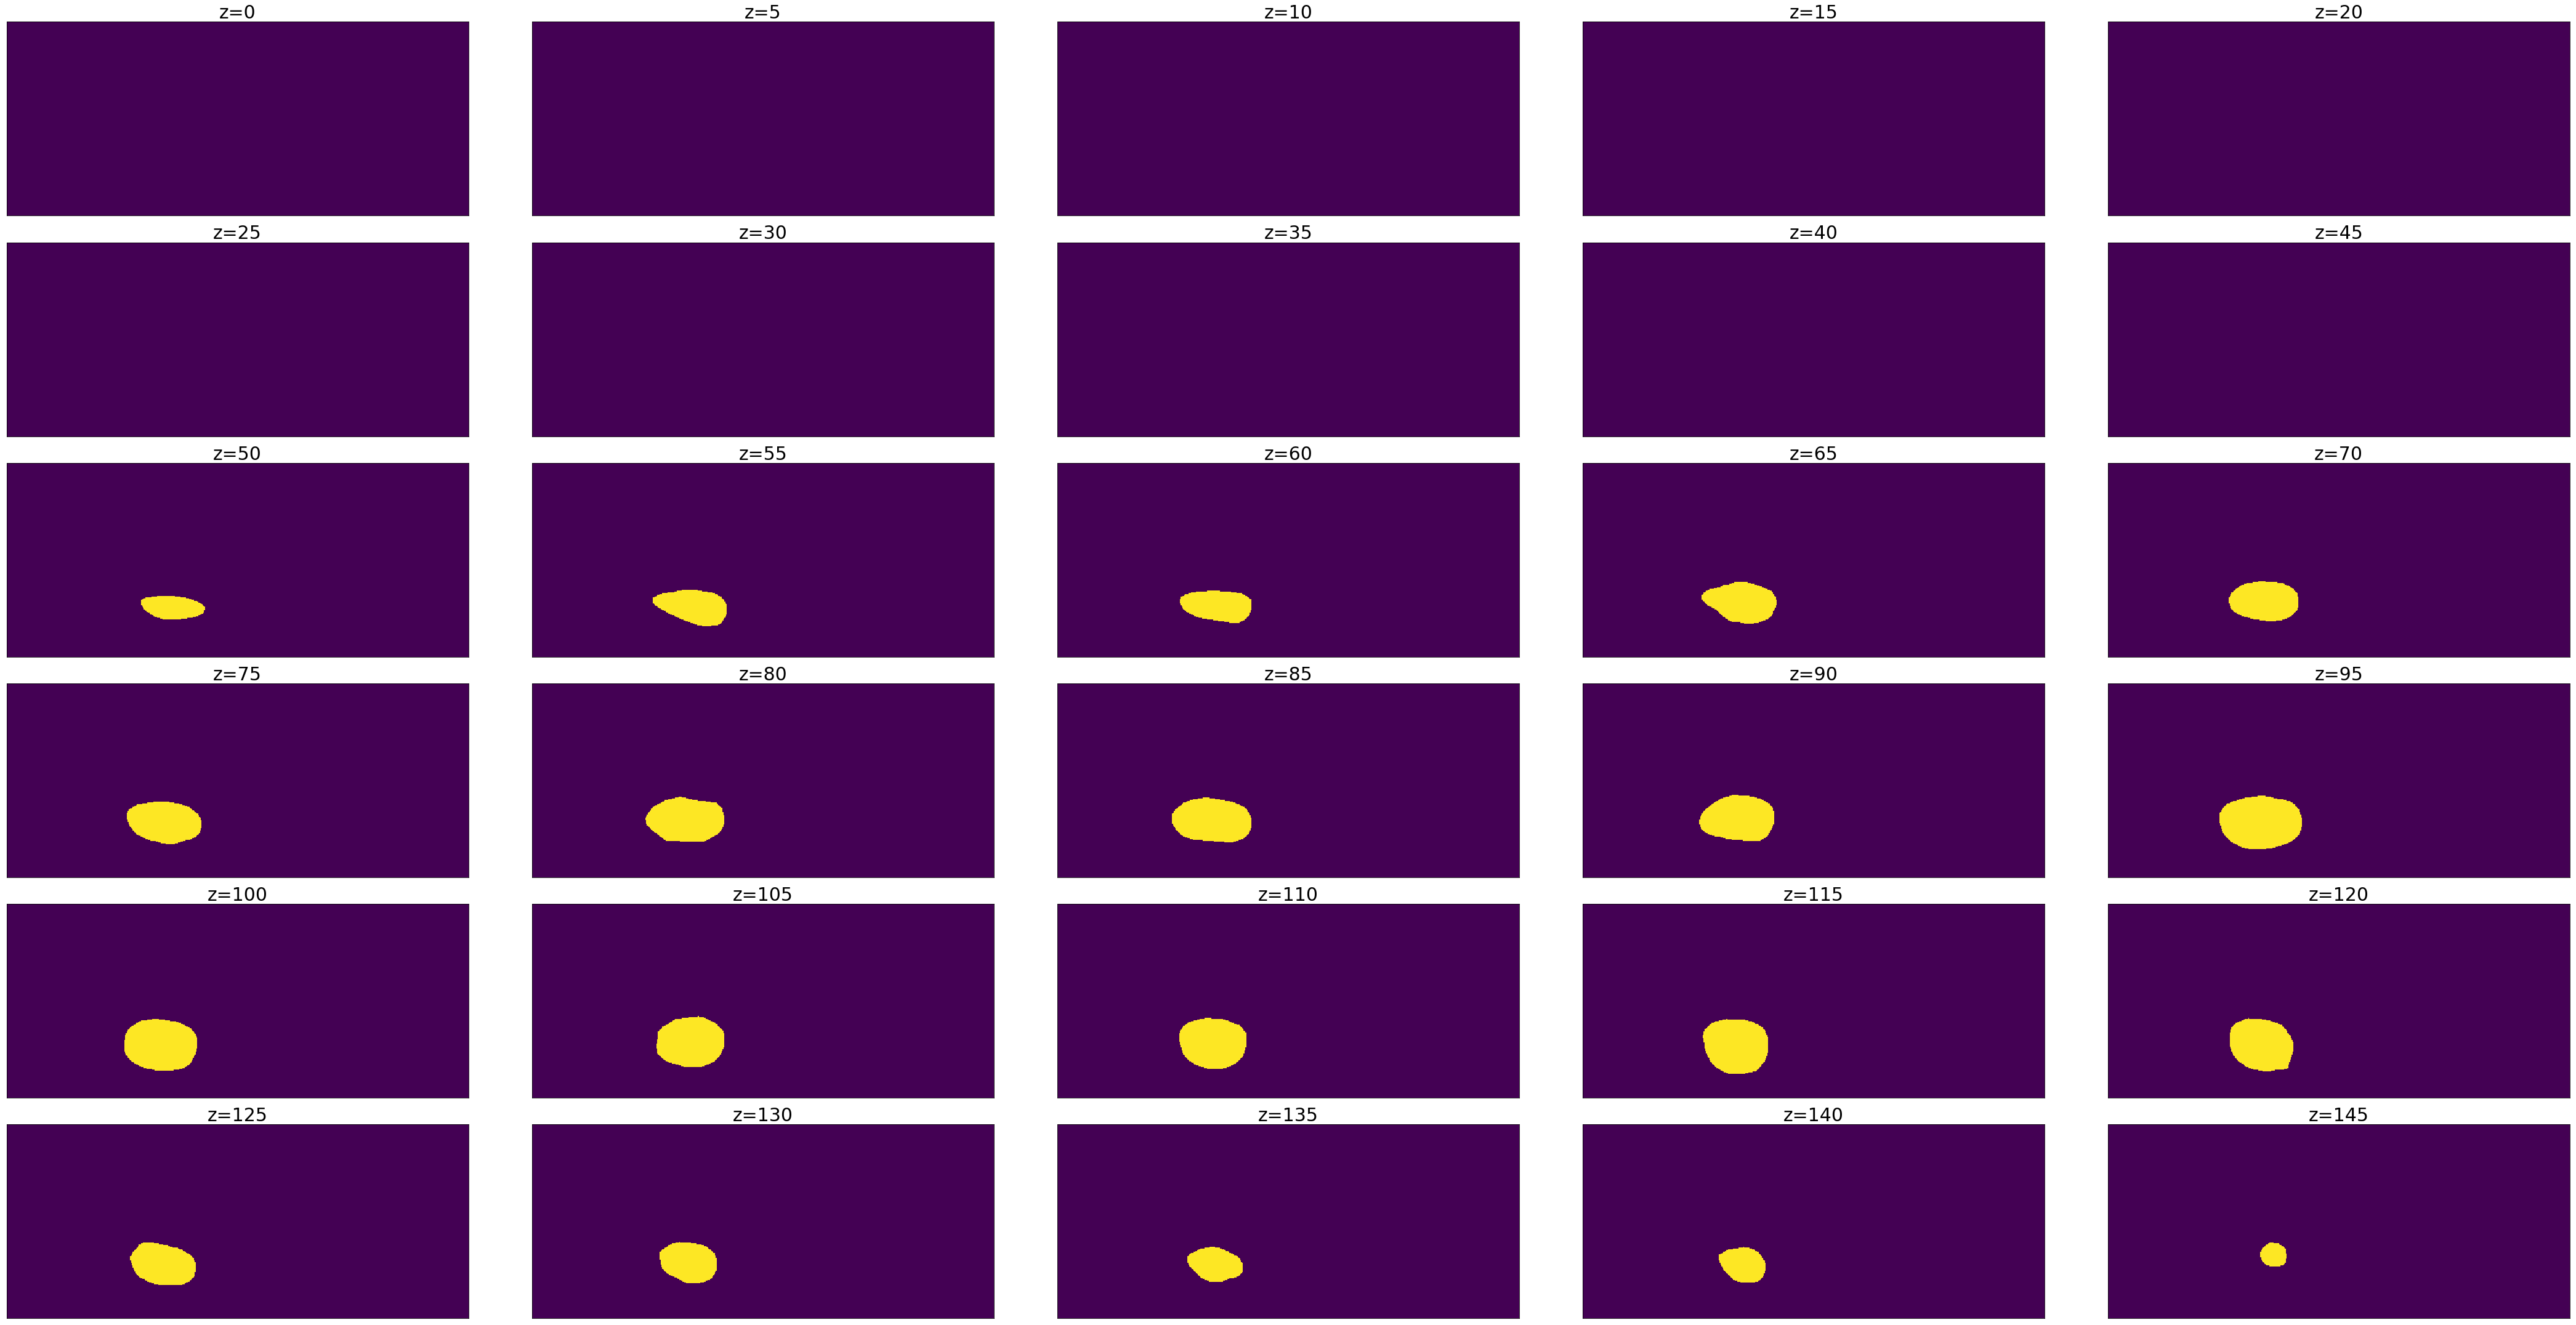

In [194]:
display_volume_sections(volume_fixed[structure_to_label_fixed['7N_L']], start_level=0)

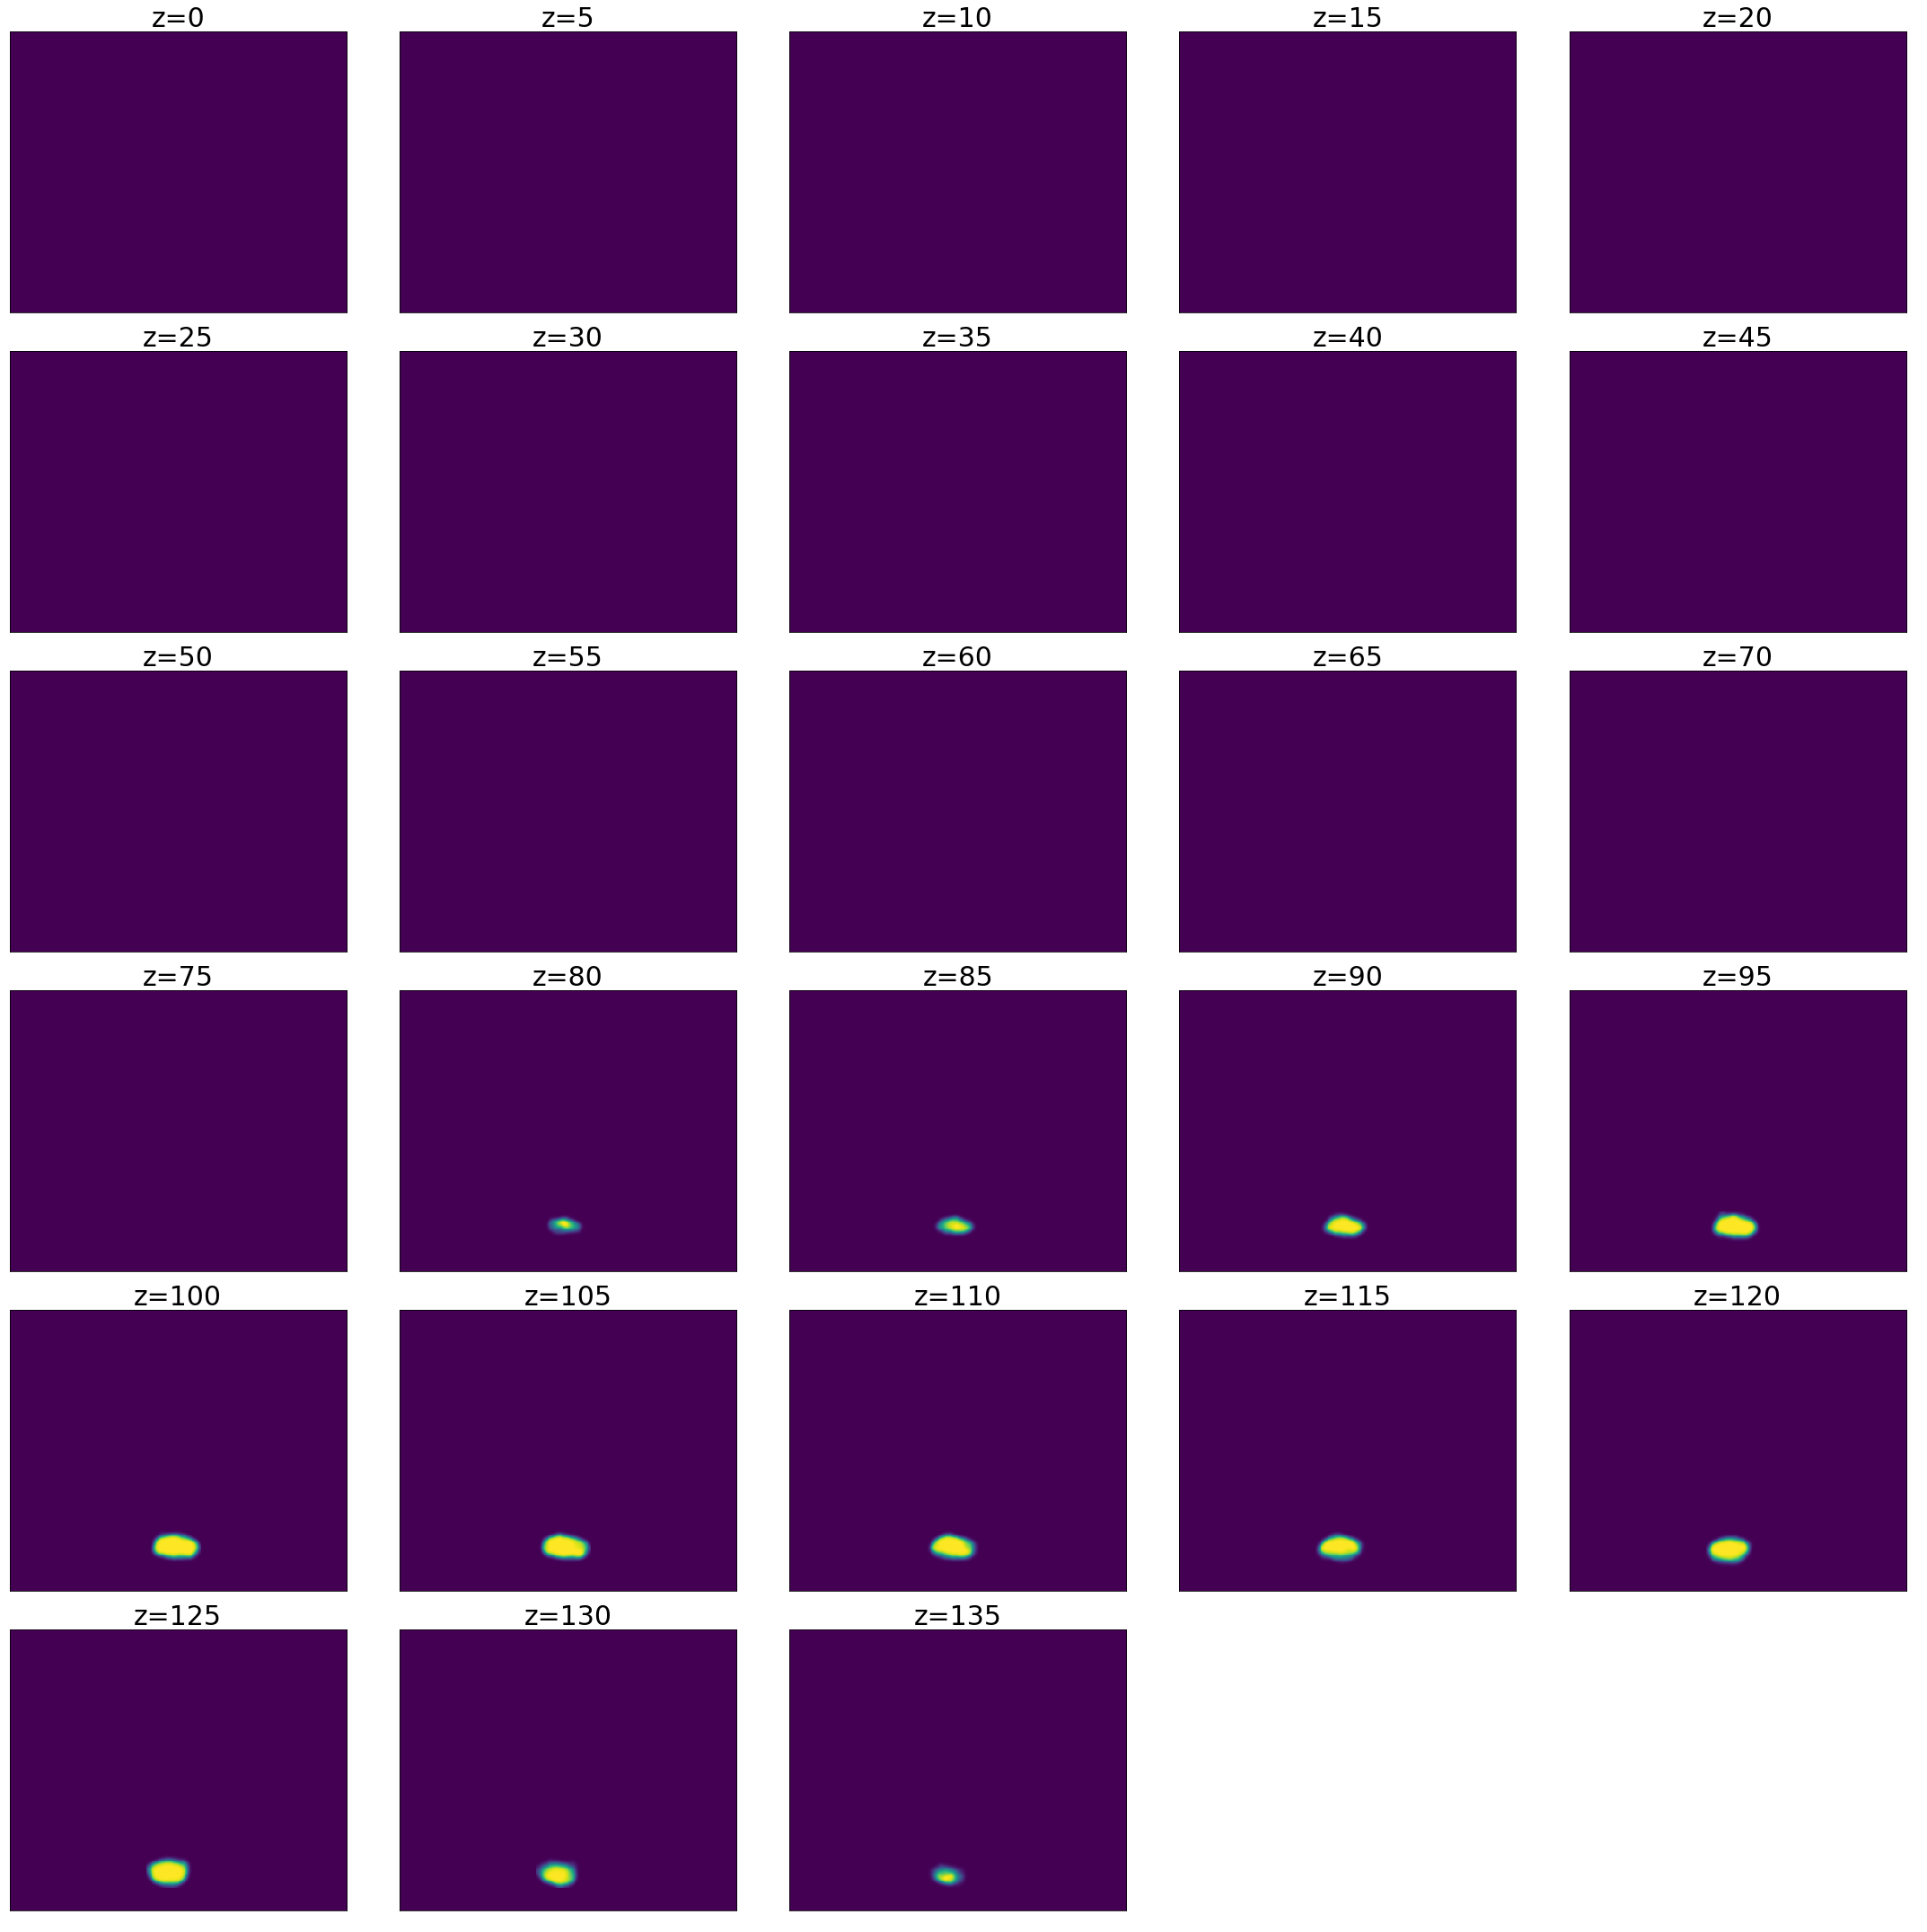

In [195]:
display_volume_sections(volume_moving[structure_to_label_moving['7N_L']], start_level=0)

In [190]:
grid_search_T, grid_search_score = aligner.do_grid_search(grid_search_iteration_number=3, 
               grid_search_sample_number=8,
              std_tx=std_tx, std_ty=std_ty, std_tz=std_tz, std_theta_xy=0,
               grid_search_eta=3., stop_radius_voxel=3)

sigma_tx: 135.87 (voxel), sigma_ty: 135.87, sigma_tz: 135.87, sigma_theta_xy: 0.00 (deg), n:8
Error computing score for 15: 15: No valid voxels after transform.
Error computing score for 16: 16: No valid voxels after transform.
Error computing score for 17: 17: No valid voxels after transform.
Error computing score for 18: 18: No valid voxels after transform.
Error computing score for 15: 15: No valid voxels after transform.
Error computing score for 18: 18: No valid voxels after transform.
Error computing score for 17: 17: No valid voxels after transform.
Error computing score for 16: 16: No valid voxels after transform.
Error computing score for 15: 15: No valid voxels after transform.
Error computing score for 16: 16: No valid voxels after transform.
Error computing score for 17: 17: No valid voxels after transform.
Error computing score for 15: 15: No valid voxels after transform.
Error computing score for 15: 15: No valid voxels after transform.
Error computing score for 18: 18: N

Error computing score for 15: 15: No valid voxels after transform.
Error computing score for 17: 17: No valid voxels after transform.
Error computing score for 18: 18: No valid voxels after transform.
Error computing score for 15: 15: No valid voxels after transform.
Error computing score for 16: 16: No valid voxels after transform.
Error computing score for 17: 17: No valid voxels after transform.
Error computing score for 16: 16: No valid voxels after transform.
Error computing score for 17: 17: No valid voxels after transform.
Error computing score for 18: 18: No valid voxels after transform.
Error computing score for 18: 18: No valid voxels after transform.
Error computing score for 15: 15: No valid voxels after transform.
Error computing score for 23: 23: No valid voxels after transform.
Error computing score for 16: 16: No valid voxels after transform.
Error computing score for 24: 24: No valid voxels after transform.
Error computing score for 25: 25: No valid voxels after transf

Error computing score for 16: 16: No valid voxels after transform.
Error computing score for 16: 16: No valid voxels after transform.
Error computing score for 26: 26: No valid voxels after transform.
Error computing score for 17: 17: No valid voxels after transform.
Error computing score for 17: 17: No valid voxels after transform.
Error computing score for 17: 17: No valid voxels after transform.
Error computing score for 17: 17: No valid voxels after transform.
Error computing score for 15: 15: No valid voxels after transform.
Error computing score for 15: 15: No valid voxels after transform.
Error computing score for 18: 18: No valid voxels after transform.
Error computing score for 18: 18: No valid voxels after transform.
Error computing score for 18: 18: No valid voxels after transform.
Error computing score for 18: 18: No valid voxels after transform.
Error computing score for 23: 23: No valid voxels after transform.
Error computing score for 16: 16: No valid voxels after transf

Error computing score for 18: 18: No valid voxels after transform.
Error computing score for 15: 15: No valid voxels after transform.
Error computing score for 17: 17: No valid voxels after transform.
Error computing score for 15: 15: No valid voxels after transform.
Error computing score for 16: 16: No valid voxels after transform.
Error computing score for 17: 17: No valid voxels after transform.
Error computing score for 18: 18: No valid voxels after transform.
Error computing score for 15: 15: No valid voxels after transform.
Error computing score for 15: 15: No valid voxels after transform.
Error computing score for 15: 15: No valid voxels after transform.
Error computing score for 17: 17: No valid voxels after transform.
Error computing score for 18: 18: No valid voxels after transform.
Error computing score for 17: 17: No valid voxels after transform.
Error computing score for 16: 16: No valid voxels after transform.
Error computing score for 16: 16: No valid voxels after transf

Error computing score for 17: 17: No valid voxels after transform.
Error computing score for 16: 16: No valid voxels after transform.
Error computing score for 17: 17: No valid voxels after transform.
Error computing score for 18: 18: No valid voxels after transform.
Error computing score for 15: 15: No valid voxels after transform.
Error computing score for 17: 17: No valid voxels after transform.
Error computing score for 23: 23: No valid voxels after transform.
Error computing score for 15: 15: No valid voxels after transform.
Error computing score for 15: 15: No valid voxels after transform.
Error computing score for 24: 24: No valid voxels after transform.
Error computing score for 16: 16: No valid voxels after transform.
Error computing score for 25: 25: No valid voxels after transform.
Error computing score for 17: 17: No valid voxels after transform.
Error computing score for 17: 17: No valid voxels after transform.
Error computing score for 18: 18: No valid voxels after transf

Error computing score for 17: 17: No valid voxels after transform.
Error computing score for 18: 18: No valid voxels after transform.
Error computing score for 15: 15: No valid voxels after transform.
Error computing score for 15: 15: No valid voxels after transform.
Error computing score for 16: 16: No valid voxels after transform.
Error computing score for 15: 15: No valid voxels after transform.
Error computing score for 16: 16: No valid voxels after transform.
Error computing score for 17: 17: No valid voxels after transform.
Error computing score for 18: 18: No valid voxels after transform.
Error computing score for 15: 15: No valid voxels after transform.
Error computing score for 16: 16: No valid voxels after transform.
Error computing score for 15: 15: No valid voxels after transform.
Error computing score for 16: 16: No valid voxels after transform.
Error computing score for 17: 17: No valid voxels after transform.
Error computing score for 18: 18: No valid voxels after transf

Error computing score for 15: 15: No valid voxels after transform.
Error computing score for 16: 16: No valid voxels after transform.
Error computing score for 15: 15: No valid voxels after transform.
Error computing score for 16: 16: No valid voxels after transform.
Error computing score for 17: 17: No valid voxels after transform.
Error computing score for 15: 15: No valid voxels after transform.
Error computing score for 16: 16: No valid voxels after transform.
Error computing score for 18: 18: No valid voxels after transform.
Error computing score for 17: 17: No valid voxels after transform.
Error computing score for 18: 18: No valid voxels after transform.
Error computing score for 23: 23: No valid voxels after transform.
Error computing score for 24: 24: No valid voxels after transform.
Error computing score for 23: 23: No valid voxels after transform.
Error computing score for 25: 25: No valid voxels after transform.
Error computing score for 24: 24: No valid voxels after transf

Error computing score for 15: 15: No valid voxels after transform.
Error computing score for 16: 16: No valid voxels after transform.
Error computing score for 16: 16: No valid voxels after transform.
Error computing score for 17: 17: No valid voxels after transform.
Error computing score for 18: 18: No valid voxels after transform.
Error computing score for 23: 23: No valid voxels after transform.
Error computing score for 24: 24: No valid voxels after transform.
Error computing score for 25: 25: No valid voxels after transform.
Error computing score for 26: 26: No valid voxels after transform.
Error computing score for 15: 15: No valid voxels after transform.
Error computing score for 16: 16: No valid voxels after transform.
Error computing score for 17: 17: No valid voxels after transform.
Error computing score for 18: 18: No valid voxels after transform.
Error computing score for 15: 15: No valid voxels after transform.
Error computing score for 16: 16: No valid voxels after transf

Error computing score for 23: 23: No valid voxels after transform.
Error computing score for 24: 24: No valid voxels after transform.
Error computing score for 25: 25: No valid voxels after transform.
Error computing score for 26: 26: No valid voxels after transform.
Error computing score for 23: 23: No valid voxels after transform.
Error computing score for 24: 24: No valid voxels after transform.
Error computing score for 25: 25: No valid voxels after transform.
Error computing score for 26: 26: No valid voxels after transform.
Error computing score for 23: 23: No valid voxels after transform.
Error computing score for 24: 24: No valid voxels after transform.
Error computing score for 25: 25: No valid voxels after transform.
Error computing score for 26: 26: No valid voxels after transform.
Error computing score for 23: 23: No valid voxels after transform.
Error computing score for 24: 24: No valid voxels after transform.
Error computing score for 25: 25: No valid voxels after transf

Error computing score for 26: 26: No valid voxels after transform.
Error computing score for 23: 23: No valid voxels after transform.
Error computing score for 24: 24: No valid voxels after transform.
Error computing score for 25: 25: No valid voxels after transform.
Error computing score for 23: 23: No valid voxels after transform.
Error computing score for 26: 26: No valid voxels after transform.
Error computing score for 24: 24: No valid voxels after transform.
Error computing score for 25: 25: No valid voxels after transform.
Error computing score for 26: 26: No valid voxels after transform.
Error computing score for 23: 23: No valid voxels after transform.
Error computing score for 24: 24: No valid voxels after transform.
Error computing score for 23: 23: No valid voxels after transform.
Error computing score for 25: 25: No valid voxels after transform.
Error computing score for 24: 24: No valid voxels after transform.
Error computing score for 26: 26: No valid voxels after transf

In [175]:
gradient_filepath_map_f = \
{ind_f: DataManager.get_volume_gradient_filepath_template(\
                                                          stack=stack_fixed, 
                                                          structure=label_to_structure_fixed[ind_f],
                                                         volume_type='annotationAsScore')
 for ind_m, ind_f in label_mapping_m2f.iteritems()}

In [176]:
gradients = {ind_f: np.zeros((3,)+volume_fixed.values()[0].shape, dtype=np.float16) 
             for ind_f in set(label_mapping_m2f.values())}

for ind_f in set(label_mapping_m2f.values()):

    t = time.time()

    download_from_s3(gradient_filepath_map_f[ind_f] % {'suffix': 'gx'}, is_dir=False)
    download_from_s3(gradient_filepath_map_f[ind_f] % {'suffix': 'gy'}, is_dir=False)
    download_from_s3(gradient_filepath_map_f[ind_f] % {'suffix': 'gz'}, is_dir=False)

    gradients[ind_f][0] = bp.unpack_ndarray_file(gradient_filepath_map_f[ind_f] % {'suffix': 'gx'})
    gradients[ind_f][1] = bp.unpack_ndarray_file(gradient_filepath_map_f[ind_f] % {'suffix': 'gy'})
    gradients[ind_f][2] = bp.unpack_ndarray_file(gradient_filepath_map_f[ind_f] % {'suffix': 'gz'})

    sys.stderr.write('load gradient %s: %f seconds\n' % (ind_f, time.time() - t)) # ~6s

load gradient 1: 1.155930 seconds
load gradient 2: 1.159574 seconds
load gradient 3: 1.150106 seconds
load gradient 4: 1.157044 seconds
load gradient 5: 1.161875 seconds
load gradient 6: 1.169696 seconds
load gradient 7: 1.163468 seconds
load gradient 8: 1.167937 seconds


In [177]:
# aligner.load_gradient(gradient_filepath_map_f=gradient_filepath_map_f) # 120s-170 = 2 mins; all 28, 220s
aligner.load_gradient(gradients=gradients)

indices_f: set([1, 2, 3, 4, 5, 6, 7, 8])


In [178]:
# Tuning learning rate:
# lr1=10., if lucky converges much faster than lr1=1., but sometimes stuck in local maxima
# If lr1=1., grad_computation_sample_number=1e5 is sufficient.

trial_num = 1

T_all_trials = []
scores_all_trials = []
traj_all_trials = []

for _ in range(trial_num):

    try:
        T, scores = aligner.optimize(tf_type=transform_type, 
#                                      max_iter_num=MAX_ITER_NUM,
                                     max_iter_num=300,
                                     history_len=HISTORY_LEN, 
                                     terminate_thresh_rot=.002,
                                     terminate_thresh_trans=.2,
#                                      grad_computation_sample_number=grad_computation_sample_number,
                                     grad_computation_sample_number=10000,
                                     lr1=lr1, lr2=lr2,
                                    init_T=grid_search_T, 
#                                      affine_scaling_limits=(.9, 1.2)
                                    )
        T_all_trials.append(T)
        scores_all_trials.append(scores)
        traj_all_trials.append(aligner.Ts)
        
    except Exception as e:
        sys.stderr.write('%s\n' % e)


iteration 0
Error computing score/gradient for 15: Image gradient at all valid voxel is zero.
Error computing score/gradient for 16: Image gradient at all valid voxel is zero.
Error computing score/gradient for 23: Image gradient at all valid voxel is zero.
Error computing score/gradient for 24: Image gradient at all valid voxel is zero.
in T: 5.50 5.50 121.96, out T: 15.50 15.50 111.96
step: 0.09 seconds
current score: -0.316253
new_T: [  15.50210965   15.50210966  111.96173698]
det: 1.10

iteration 1
Error computing score/gradient for 15: Image gradient at all valid voxel is zero.
Error computing score/gradient for 16: Image gradient at all valid voxel is zero.
Error computing score/gradient for 23: Image gradient at all valid voxel is zero.
Error computing score/gradient for 24: Image gradient at all valid voxel is zero.
in T: 15.50 15.50 111.96, out T: 25.41 6.40 113.88
step: 0.09 seconds
current score: -0.315713
new_T: [  25.40559307    6.39521066  113.87924371]
det: 1.10

iterat

in T: 3.84 9.08 117.81, out T: 8.55 7.75 116.32
step: 0.09 seconds
current score: -0.313395
new_T: [   8.55396093    7.75484166  116.31530871]
det: 1.56

iteration 18
Error computing score/gradient for 15: Image gradient at all valid voxel is zero.
Error computing score/gradient for 16: Image gradient at all valid voxel is zero.
Error computing score/gradient for 23: Image gradient at all valid voxel is zero.
Error computing score/gradient for 24: Image gradient at all valid voxel is zero.
in T: 8.55 7.75 116.32, out T: 7.16 8.90 117.92
step: 0.10 seconds
current score: -0.312980
new_T: [   7.16089707    8.90111034  117.91917464]
det: 1.60

iteration 19
Error computing score/gradient for 15: Image gradient at all valid voxel is zero.
Error computing score/gradient for 16: Image gradient at all valid voxel is zero.
Error computing score/gradient for 23: Image gradient at all valid voxel is zero.
Error computing score/gradient for 24: Image gradient at all valid voxel is zero.
in T: 7.16

in T: 6.41 6.80 117.37, out T: 7.35 8.66 116.65
step: 0.10 seconds
current score: -0.312921
new_T: [   7.35432763    8.65716931  116.6525493 ]
det: 1.63

iteration 35
Error computing score/gradient for 15: Image gradient at all valid voxel is zero.
Error computing score/gradient for 16: Image gradient at all valid voxel is zero.
Error computing score/gradient for 23: Image gradient at all valid voxel is zero.
Error computing score/gradient for 24: Image gradient at all valid voxel is zero.
in T: 7.35 8.66 116.65, out T: 5.79 7.21 117.26
step: 0.09 seconds
current score: -0.312978
new_T: [   5.78956082    7.21096451  117.25701072]
det: 1.62

iteration 36
Error computing score/gradient for 15: Image gradient at all valid voxel is zero.
Error computing score/gradient for 16: Image gradient at all valid voxel is zero.
Error computing score/gradient for 23: Image gradient at all valid voxel is zero.
Error computing score/gradient for 24: Image gradient at all valid voxel is zero.
in T: 5.79

in T: 6.85 7.71 116.97, out T: 5.93 8.19 118.00
step: 0.09 seconds
current score: -0.312923
new_T: [   5.93128685    8.19081118  118.00081681]
det: 1.64

iteration 53
Error computing score/gradient for 15: Image gradient at all valid voxel is zero.
Error computing score/gradient for 16: Image gradient at all valid voxel is zero.
Error computing score/gradient for 23: Image gradient at all valid voxel is zero.
Error computing score/gradient for 24: Image gradient at all valid voxel is zero.
in T: 5.93 8.19 118.00, out T: 6.43 7.90 115.89
step: 0.09 seconds
current score: -0.313007
new_T: [   6.43138563    7.90253041  115.89281044]
det: 1.61

iteration 54
Error computing score/gradient for 15: Image gradient at all valid voxel is zero.
Error computing score/gradient for 16: Image gradient at all valid voxel is zero.
Error computing score/gradient for 23: Image gradient at all valid voxel is zero.
Error computing score/gradient for 24: Image gradient at all valid voxel is zero.
in T: 6.43

in T: 6.17 7.62 116.86, out T: 6.45 8.28 117.80
step: 0.09 seconds
current score: -0.312900
new_T: [   6.45116197    8.28194344  117.80389871]
det: 1.64

iteration 70
Error computing score/gradient for 15: Image gradient at all valid voxel is zero.
Error computing score/gradient for 16: Image gradient at all valid voxel is zero.
Error computing score/gradient for 23: Image gradient at all valid voxel is zero.
Error computing score/gradient for 24: Image gradient at all valid voxel is zero.
in T: 6.45 8.28 117.80, out T: 6.96 8.03 116.63
step: 0.09 seconds
current score: -0.312901
new_T: [   6.95760479    8.02767318  116.63362152]
det: 1.62

iteration 71
Error computing score/gradient for 15: Image gradient at all valid voxel is zero.
Error computing score/gradient for 16: Image gradient at all valid voxel is zero.
Error computing score/gradient for 23: Image gradient at all valid voxel is zero.
Error computing score/gradient for 24: Image gradient at all valid voxel is zero.
in T: 6.96

in T: 6.25 8.23 117.37, out T: 7.28 7.39 117.57
step: 0.09 seconds
current score: -0.312925
new_T: [   7.28364581    7.38726918  117.57419116]
det: 1.63

iteration 88
Error computing score/gradient for 15: Image gradient at all valid voxel is zero.
Error computing score/gradient for 16: Image gradient at all valid voxel is zero.
Error computing score/gradient for 23: Image gradient at all valid voxel is zero.
Error computing score/gradient for 24: Image gradient at all valid voxel is zero.
in T: 7.28 7.39 117.57, out T: 6.49 8.51 117.74
step: 0.09 seconds
current score: -0.313011
new_T: [   6.49147495    8.51023677  117.73564584]
det: 1.64

iteration 89
Error computing score/gradient for 15: Image gradient at all valid voxel is zero.
Error computing score/gradient for 16: Image gradient at all valid voxel is zero.
Error computing score/gradient for 23: Image gradient at all valid voxel is zero.
Error computing score/gradient for 24: Image gradient at all valid voxel is zero.
in T: 6.49

in T: 6.39 7.73 117.35, out T: 6.78 8.00 116.82
step: 0.09 seconds
current score: -0.312813
new_T: [   6.78057399    8.00178201  116.82325744]
det: 1.62

iteration 105
Error computing score/gradient for 15: Image gradient at all valid voxel is zero.
Error computing score/gradient for 16: Image gradient at all valid voxel is zero.
Error computing score/gradient for 23: Image gradient at all valid voxel is zero.
Error computing score/gradient for 24: Image gradient at all valid voxel is zero.
in T: 6.78 8.00 116.82, out T: 5.89 7.91 117.65
step: 0.09 seconds
current score: -0.312992
new_T: [   5.89459088    7.90520854  117.65154841]
det: 1.63

iteration 106
Error computing score/gradient for 15: Image gradient at all valid voxel is zero.
Error computing score/gradient for 16: Image gradient at all valid voxel is zero.
Error computing score/gradient for 23: Image gradient at all valid voxel is zero.
Error computing score/gradient for 24: Image gradient at all valid voxel is zero.
in T: 5.

Error computing score/gradient for 24: Image gradient at all valid voxel is zero.
in T: 6.77 8.22 117.28, out T: 5.74 7.94 117.18
step: 0.09 seconds
current score: -0.312925
new_T: [   5.73609601    7.94120464  117.17667301]
det: 1.63

iteration 123
Error computing score/gradient for 15: Image gradient at all valid voxel is zero.
Error computing score/gradient for 16: Image gradient at all valid voxel is zero.
Error computing score/gradient for 23: Image gradient at all valid voxel is zero.
Error computing score/gradient for 24: Image gradient at all valid voxel is zero.
in T: 5.74 7.94 117.18, out T: 6.30 7.68 116.91
step: 0.09 seconds
current score: -0.312916
new_T: [   6.29767419    7.67703411  116.90989468]
det: 1.63

iteration 124
Error computing score/gradient for 15: Image gradient at all valid voxel is zero.
Error computing score/gradient for 16: Image gradient at all valid voxel is zero.
Error computing score/gradient for 23: Image gradient at all valid voxel is zero.
Error co

Error computing score/gradient for 23: Image gradient at all valid voxel is zero.
Error computing score/gradient for 24: Image gradient at all valid voxel is zero.
in T: 6.15 8.25 117.77, out T: 6.45 7.52 116.83
step: 0.09 seconds
current score: -0.312941
new_T: [   6.45475677    7.51905984  116.83159091]
det: 1.62

iteration 140
Error computing score/gradient for 15: Image gradient at all valid voxel is zero.
Error computing score/gradient for 16: Image gradient at all valid voxel is zero.
Error computing score/gradient for 23: Image gradient at all valid voxel is zero.
Error computing score/gradient for 24: Image gradient at all valid voxel is zero.
in T: 6.45 7.52 116.83, out T: 6.63 7.99 117.77
step: 0.09 seconds
current score: -0.312912
new_T: [   6.63342531    7.99148667  117.76653112]
det: 1.64

iteration 141
Error computing score/gradient for 15: Image gradient at all valid voxel is zero.
Error computing score/gradient for 16: Image gradient at all valid voxel is zero.
Error co

Error computing score/gradient for 23: Image gradient at all valid voxel is zero.
Error computing score/gradient for 24: Image gradient at all valid voxel is zero.
in T: 6.65 7.38 117.38, out T: 6.34 8.24 117.35
step: 0.09 seconds
current score: -0.312940
new_T: [   6.34366365    8.24061171  117.35357184]
det: 1.63

iteration 158
Error computing score/gradient for 15: Image gradient at all valid voxel is zero.
Error computing score/gradient for 16: Image gradient at all valid voxel is zero.
Error computing score/gradient for 23: Image gradient at all valid voxel is zero.
Error computing score/gradient for 24: Image gradient at all valid voxel is zero.
in T: 6.34 8.24 117.35, out T: 6.17 7.66 117.30
step: 0.09 seconds
current score: -0.312910
new_T: [   6.16692396    7.66117065  117.30470663]
det: 1.62

iteration 159
Error computing score/gradient for 15: Image gradient at all valid voxel is zero.
Error computing score/gradient for 16: Image gradient at all valid voxel is zero.
Error co

Error computing score/gradient for 23: Image gradient at all valid voxel is zero.
Error computing score/gradient for 24: Image gradient at all valid voxel is zero.
in T: 6.45 8.13 117.32, out T: 6.21 8.09 117.25
step: 0.09 seconds
current score: -0.312897
new_T: [   6.20878289    8.09198892  117.24857408]
det: 1.63

iteration 175
Error computing score/gradient for 15: Image gradient at all valid voxel is zero.
Error computing score/gradient for 16: Image gradient at all valid voxel is zero.
Error computing score/gradient for 23: Image gradient at all valid voxel is zero.
Error computing score/gradient for 24: Image gradient at all valid voxel is zero.
in T: 6.21 8.09 117.25, out T: 7.21 8.05 117.30
step: 0.09 seconds
current score: -0.312900
new_T: [   7.21237078    8.04610879  117.29918227]
det: 1.63

iteration 176
Error computing score/gradient for 15: Image gradient at all valid voxel is zero.
Error computing score/gradient for 16: Image gradient at all valid voxel is zero.
Error co

Error computing score/gradient for 23: Image gradient at all valid voxel is zero.
Error computing score/gradient for 24: Image gradient at all valid voxel is zero.
in T: 6.62 7.98 117.50, out T: 6.34 8.03 116.92
step: 0.09 seconds
current score: -0.312832
new_T: [   6.34354137    8.02973863  116.91920244]
det: 1.61

iteration 193
Error computing score/gradient for 15: Image gradient at all valid voxel is zero.
Error computing score/gradient for 16: Image gradient at all valid voxel is zero.
Error computing score/gradient for 23: Image gradient at all valid voxel is zero.
Error computing score/gradient for 24: Image gradient at all valid voxel is zero.
in T: 6.34 8.03 116.92, out T: 6.68 7.86 117.31
step: 0.09 seconds
current score: -0.312924
new_T: [   6.67830095    7.85719536  117.30954166]
det: 1.62

iteration 194
Error computing score/gradient for 15: Image gradient at all valid voxel is zero.
Error computing score/gradient for 16: Image gradient at all valid voxel is zero.
Error co

Error computing score/gradient for 23: Image gradient at all valid voxel is zero.
Error computing score/gradient for 24: Image gradient at all valid voxel is zero.
in T: 6.04 7.57 117.54, out T: 6.26 8.21 117.26
step: 0.09 seconds
current score: -0.312946
new_T: [   6.25643418    8.20625098  117.26183963]
det: 1.62

iteration 210
Error computing score/gradient for 15: Image gradient at all valid voxel is zero.
Error computing score/gradient for 16: Image gradient at all valid voxel is zero.
Error computing score/gradient for 23: Image gradient at all valid voxel is zero.
Error computing score/gradient for 24: Image gradient at all valid voxel is zero.
in T: 6.26 8.21 117.26, out T: 6.38 7.88 117.49
step: 0.09 seconds
current score: -0.312914
new_T: [   6.38128748    7.88233805  117.49412864]
det: 1.63

iteration 211
Error computing score/gradient for 15: Image gradient at all valid voxel is zero.
Error computing score/gradient for 16: Image gradient at all valid voxel is zero.
Error co

Error computing score/gradient for 16: Image gradient at all valid voxel is zero.
Error computing score/gradient for 23: Image gradient at all valid voxel is zero.
Error computing score/gradient for 24: Image gradient at all valid voxel is zero.
in T: 6.14 7.79 117.12, out T: 6.53 7.70 117.90
step: 0.09 seconds
current score: -0.312940
new_T: [   6.5285191     7.69541861  117.89846989]
det: 1.63

iteration 229
Error computing score/gradient for 15: Image gradient at all valid voxel is zero.
Error computing score/gradient for 16: Image gradient at all valid voxel is zero.
Error computing score/gradient for 23: Image gradient at all valid voxel is zero.
Error computing score/gradient for 24: Image gradient at all valid voxel is zero.
in T: 6.53 7.70 117.90, out T: 7.08 7.51 117.24
step: 0.09 seconds
current score: -0.312915
new_T: [   7.08187993    7.51062634  117.23552112]
det: 1.62

iteration 230
Error computing score/gradient for 15: Image gradient at all valid voxel is zero.
Error co

Error computing score/gradient for 16: Image gradient at all valid voxel is zero.
Error computing score/gradient for 23: Image gradient at all valid voxel is zero.
Error computing score/gradient for 24: Image gradient at all valid voxel is zero.
in T: 6.60 7.81 117.75, out T: 6.64 8.01 117.11
step: 0.09 seconds
current score: -0.312860
new_T: [   6.63942174    8.01375418  117.10542751]
det: 1.61

iteration 246
Error computing score/gradient for 15: Image gradient at all valid voxel is zero.
Error computing score/gradient for 16: Image gradient at all valid voxel is zero.
Error computing score/gradient for 23: Image gradient at all valid voxel is zero.
Error computing score/gradient for 24: Image gradient at all valid voxel is zero.
in T: 6.64 8.01 117.11, out T: 6.96 7.53 117.53
step: 0.09 seconds
current score: -0.312891
new_T: [   6.96170811    7.5317834   117.53490566]
det: 1.62

iteration 247
Error computing score/gradient for 15: Image gradient at all valid voxel is zero.
Error co

Error computing score/gradient for 23: Image gradient at all valid voxel is zero.
Error computing score/gradient for 24: Image gradient at all valid voxel is zero.
in T: 6.20 7.86 117.17, out T: 6.24 7.62 117.62
step: 0.09 seconds
current score: -0.312855
new_T: [   6.23658699    7.61861935  117.61956597]
det: 1.61

iteration 263
Error computing score/gradient for 15: Image gradient at all valid voxel is zero.
Error computing score/gradient for 16: Image gradient at all valid voxel is zero.
Error computing score/gradient for 23: Image gradient at all valid voxel is zero.
Error computing score/gradient for 24: Image gradient at all valid voxel is zero.
in T: 6.24 7.62 117.62, out T: 6.81 8.02 117.36
step: 0.09 seconds
current score: -0.312924
new_T: [   6.80982458    8.01977547  117.35984838]
det: 1.62

iteration 264
Error computing score/gradient for 15: Image gradient at all valid voxel is zero.
Error computing score/gradient for 16: Image gradient at all valid voxel is zero.
Error co

in T: 6.98 7.67 117.25, out T: 6.44 8.19 117.49
step: 0.09 seconds
current score: -0.312998
new_T: [   6.43965238    8.1870816   117.49382315]
det: 1.62

iteration 280
Error computing score/gradient for 15: Image gradient at all valid voxel is zero.
Error computing score/gradient for 16: Image gradient at all valid voxel is zero.
Error computing score/gradient for 23: Image gradient at all valid voxel is zero.
Error computing score/gradient for 24: Image gradient at all valid voxel is zero.
in T: 6.44 8.19 117.49, out T: 5.73 8.06 118.24
step: 0.09 seconds
current score: -0.313005
new_T: [   5.73094884    8.06466438  118.2436012 ]
det: 1.63

iteration 281
Error computing score/gradient for 15: Image gradient at all valid voxel is zero.
Error computing score/gradient for 16: Image gradient at all valid voxel is zero.
Error computing score/gradient for 23: Image gradient at all valid voxel is zero.
Error computing score/gradient for 24: Image gradient at all valid voxel is zero.
in T: 5.

Error computing score/gradient for 23: Image gradient at all valid voxel is zero.
Error computing score/gradient for 24: Image gradient at all valid voxel is zero.
in T: 6.75 8.04 118.08, out T: 6.37 8.01 117.60
step: 0.09 seconds
current score: -0.312969
new_T: [   6.36684491    8.01289568  117.6032916 ]
det: 1.62

iteration 298
Error computing score/gradient for 15: Image gradient at all valid voxel is zero.
Error computing score/gradient for 16: Image gradient at all valid voxel is zero.
Error computing score/gradient for 23: Image gradient at all valid voxel is zero.
Error computing score/gradient for 24: Image gradient at all valid voxel is zero.
in T: 6.37 8.01 117.60, out T: 6.34 7.88 118.32
step: 0.09 seconds
current score: -0.312924
new_T: [   6.33667776    7.88287355  118.32164003]
det: 1.63

iteration 299
Error computing score/gradient for 15: Image gradient at all valid voxel is zero.
Error computing score/gradient for 16: Image gradient at all valid voxel is zero.
Error co

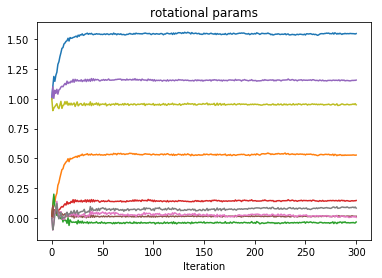

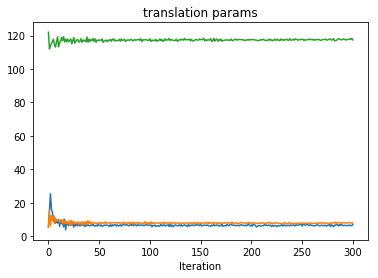

In [179]:
Ts = np.array(aligner.Ts)

plt.plot(Ts[:, [0,1,2,4,5,6,8,9,10]]);
plt.title('rotational params');
plt.xlabel('Iteration');
plt.show();

plt.plot(Ts[:, [3,7,11]]);
plt.title('translation params');
plt.xlabel('Iteration');
plt.show();

Best trial: 0
-0.229578020773 -0.31300227931
[[  1.18669590e+00   1.82005629e-01   1.99916611e-01   2.54055931e+01]
 [  3.79091820e-03   1.00318305e+00   9.42028770e-03   6.39521066e+00]
 [ -3.62005831e-02  -5.43852558e-02   9.20479139e-01   1.13879244e+02]]


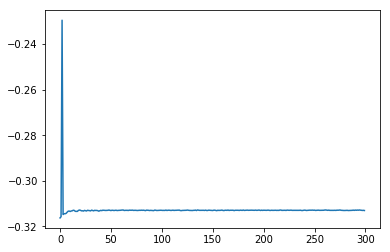

In [180]:
best_trial = np.argsort([np.max(scores) for scores in scores_all_trials])[-1]
# best_trial = 1
T = T_all_trials[best_trial]
scores = scores_all_trials[best_trial]
print 'Best trial:', best_trial
print max(scores), scores[-1]

print T.reshape((3,4))
plt.figure();
plt.plot(scores);
plt.show();

In [181]:
global_params, centroid_m, centroid_f, xdim_m, ydim_m, zdim_m, xdim_f, ydim_f, zdim_f = \
(T, 
  aligner.centroid_m, aligner.centroid_f,
  aligner.xdim_m, aligner.ydim_m, aligner.zdim_m, 
  aligner.xdim_f, aligner.ydim_f, aligner.zdim_f)

In [186]:
structure = '5N_L'

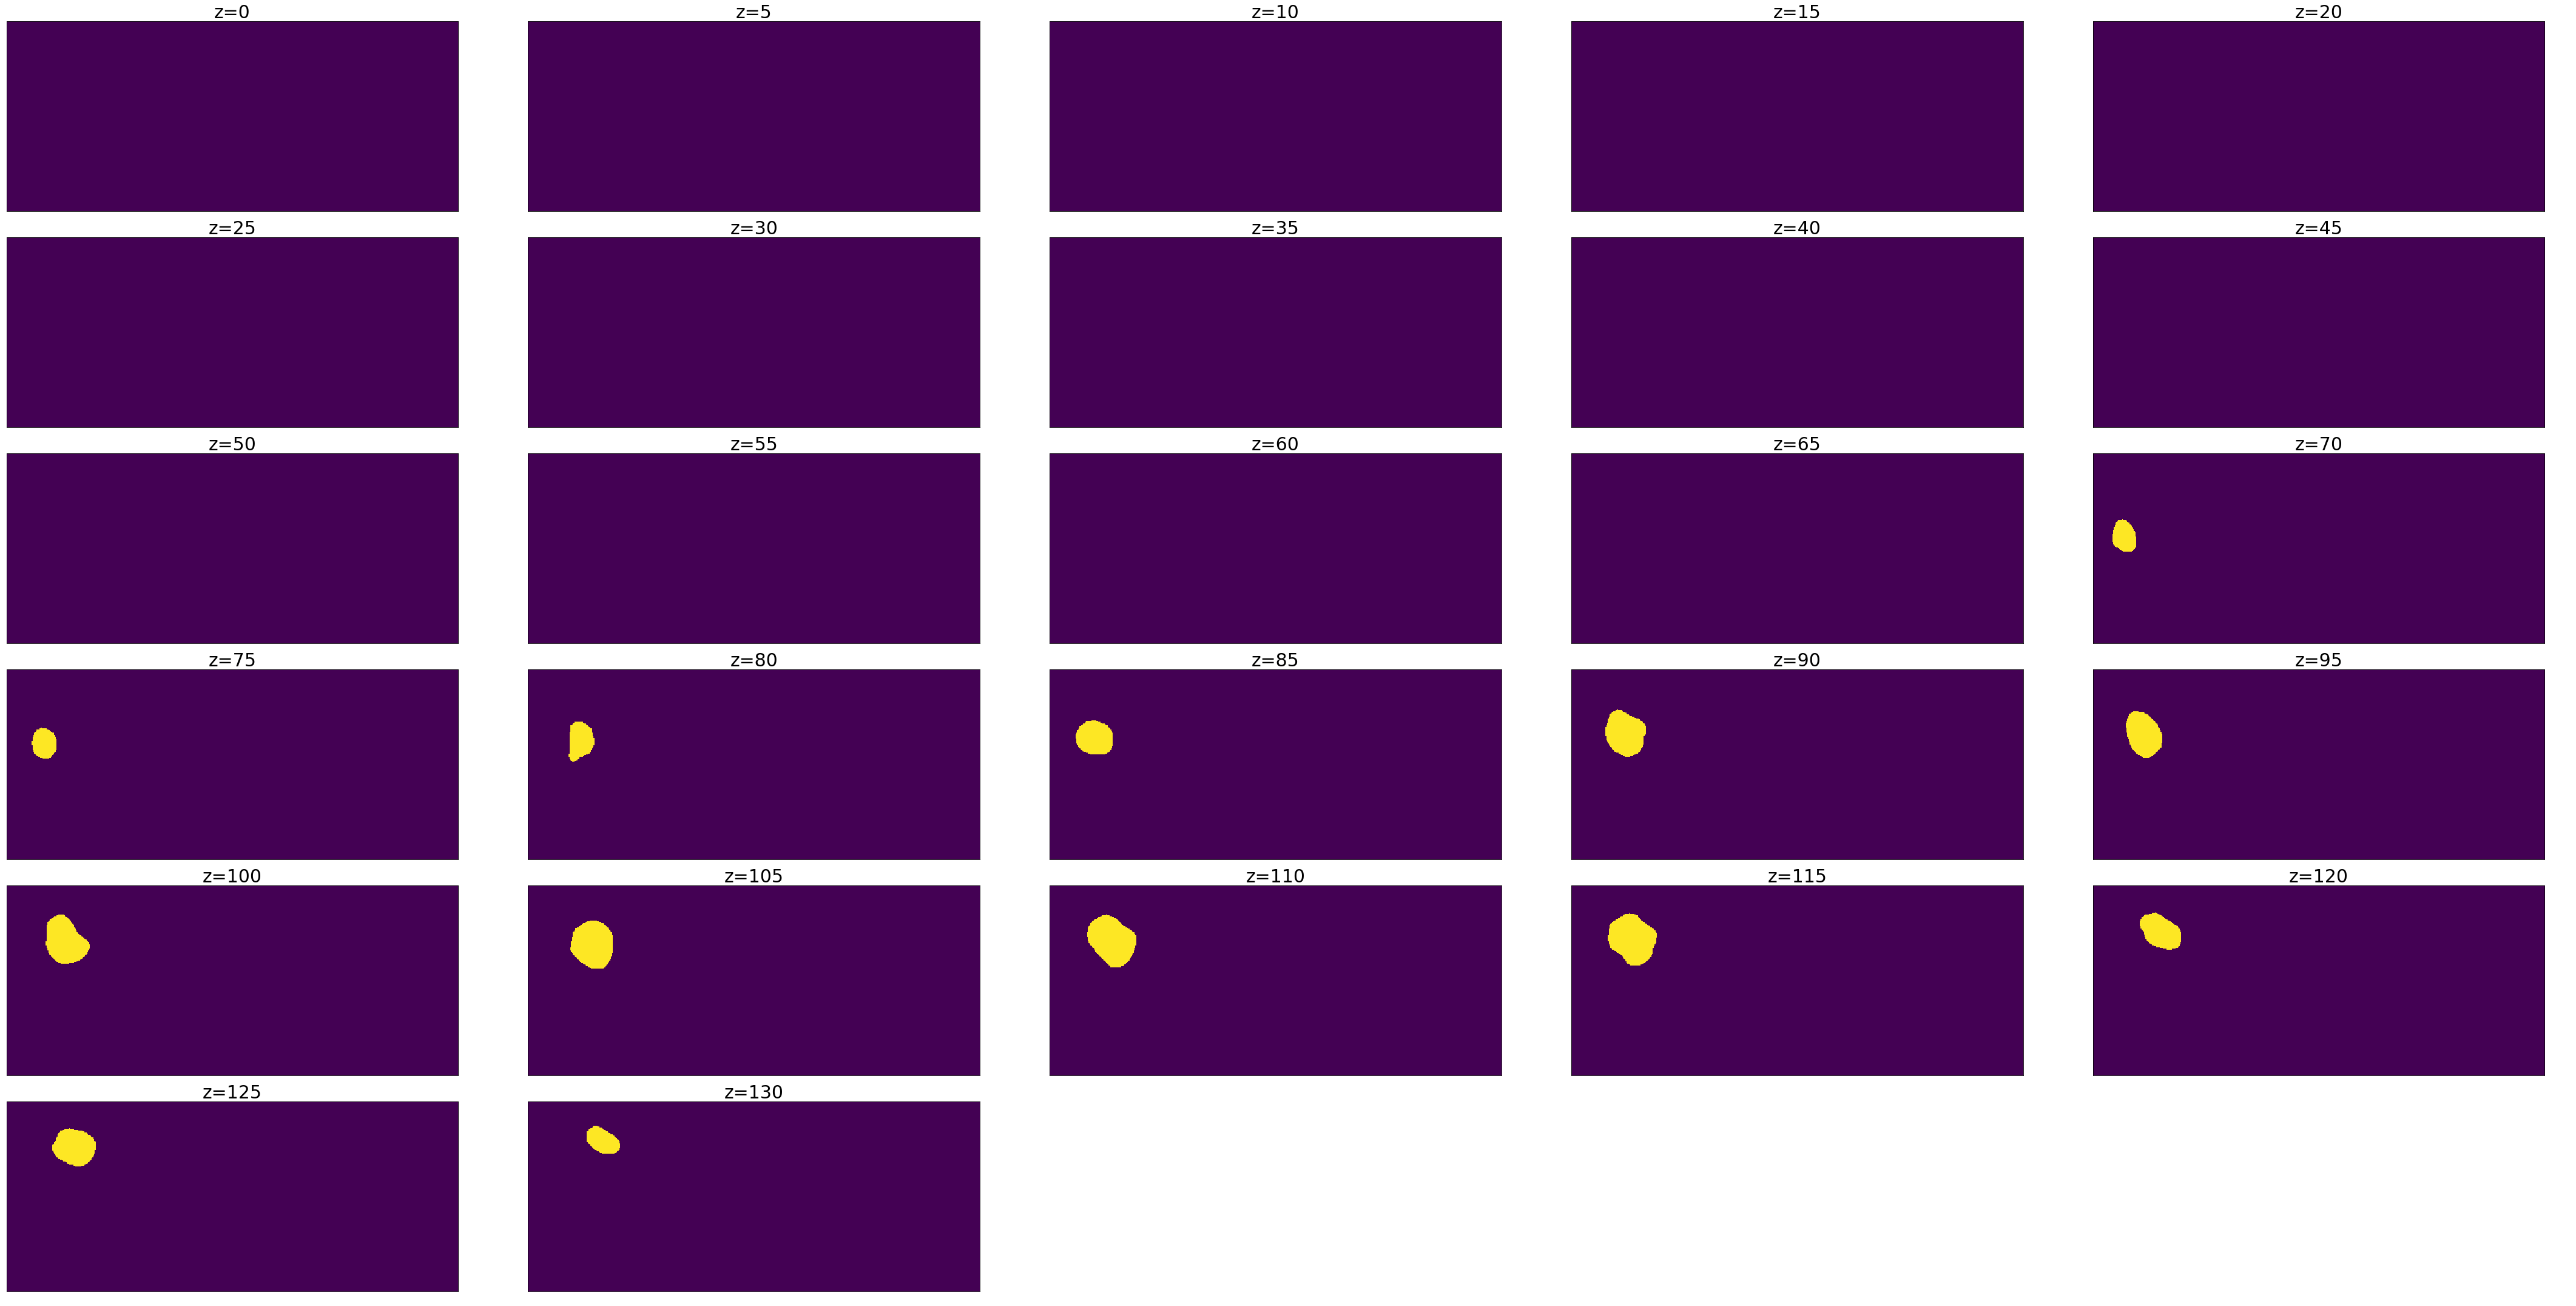

In [187]:
display_volume_sections(volume_fixed[structure_to_label_fixed[structure]], start_level=0)

In [188]:
# vol_m = DataManager.load_original_volume(stack=stack_moving, structure=structure, downscale=32)

vol_m = volume_moving[structure_to_label_moving[structure]]

volume_m_alignedTo_f, volume_m_alignedTo_f_bbox = \
transform_volume_v2(vol=vol_m, tf_params=global_params, centroid_m=centroid_m, centroid_f=centroid_f)

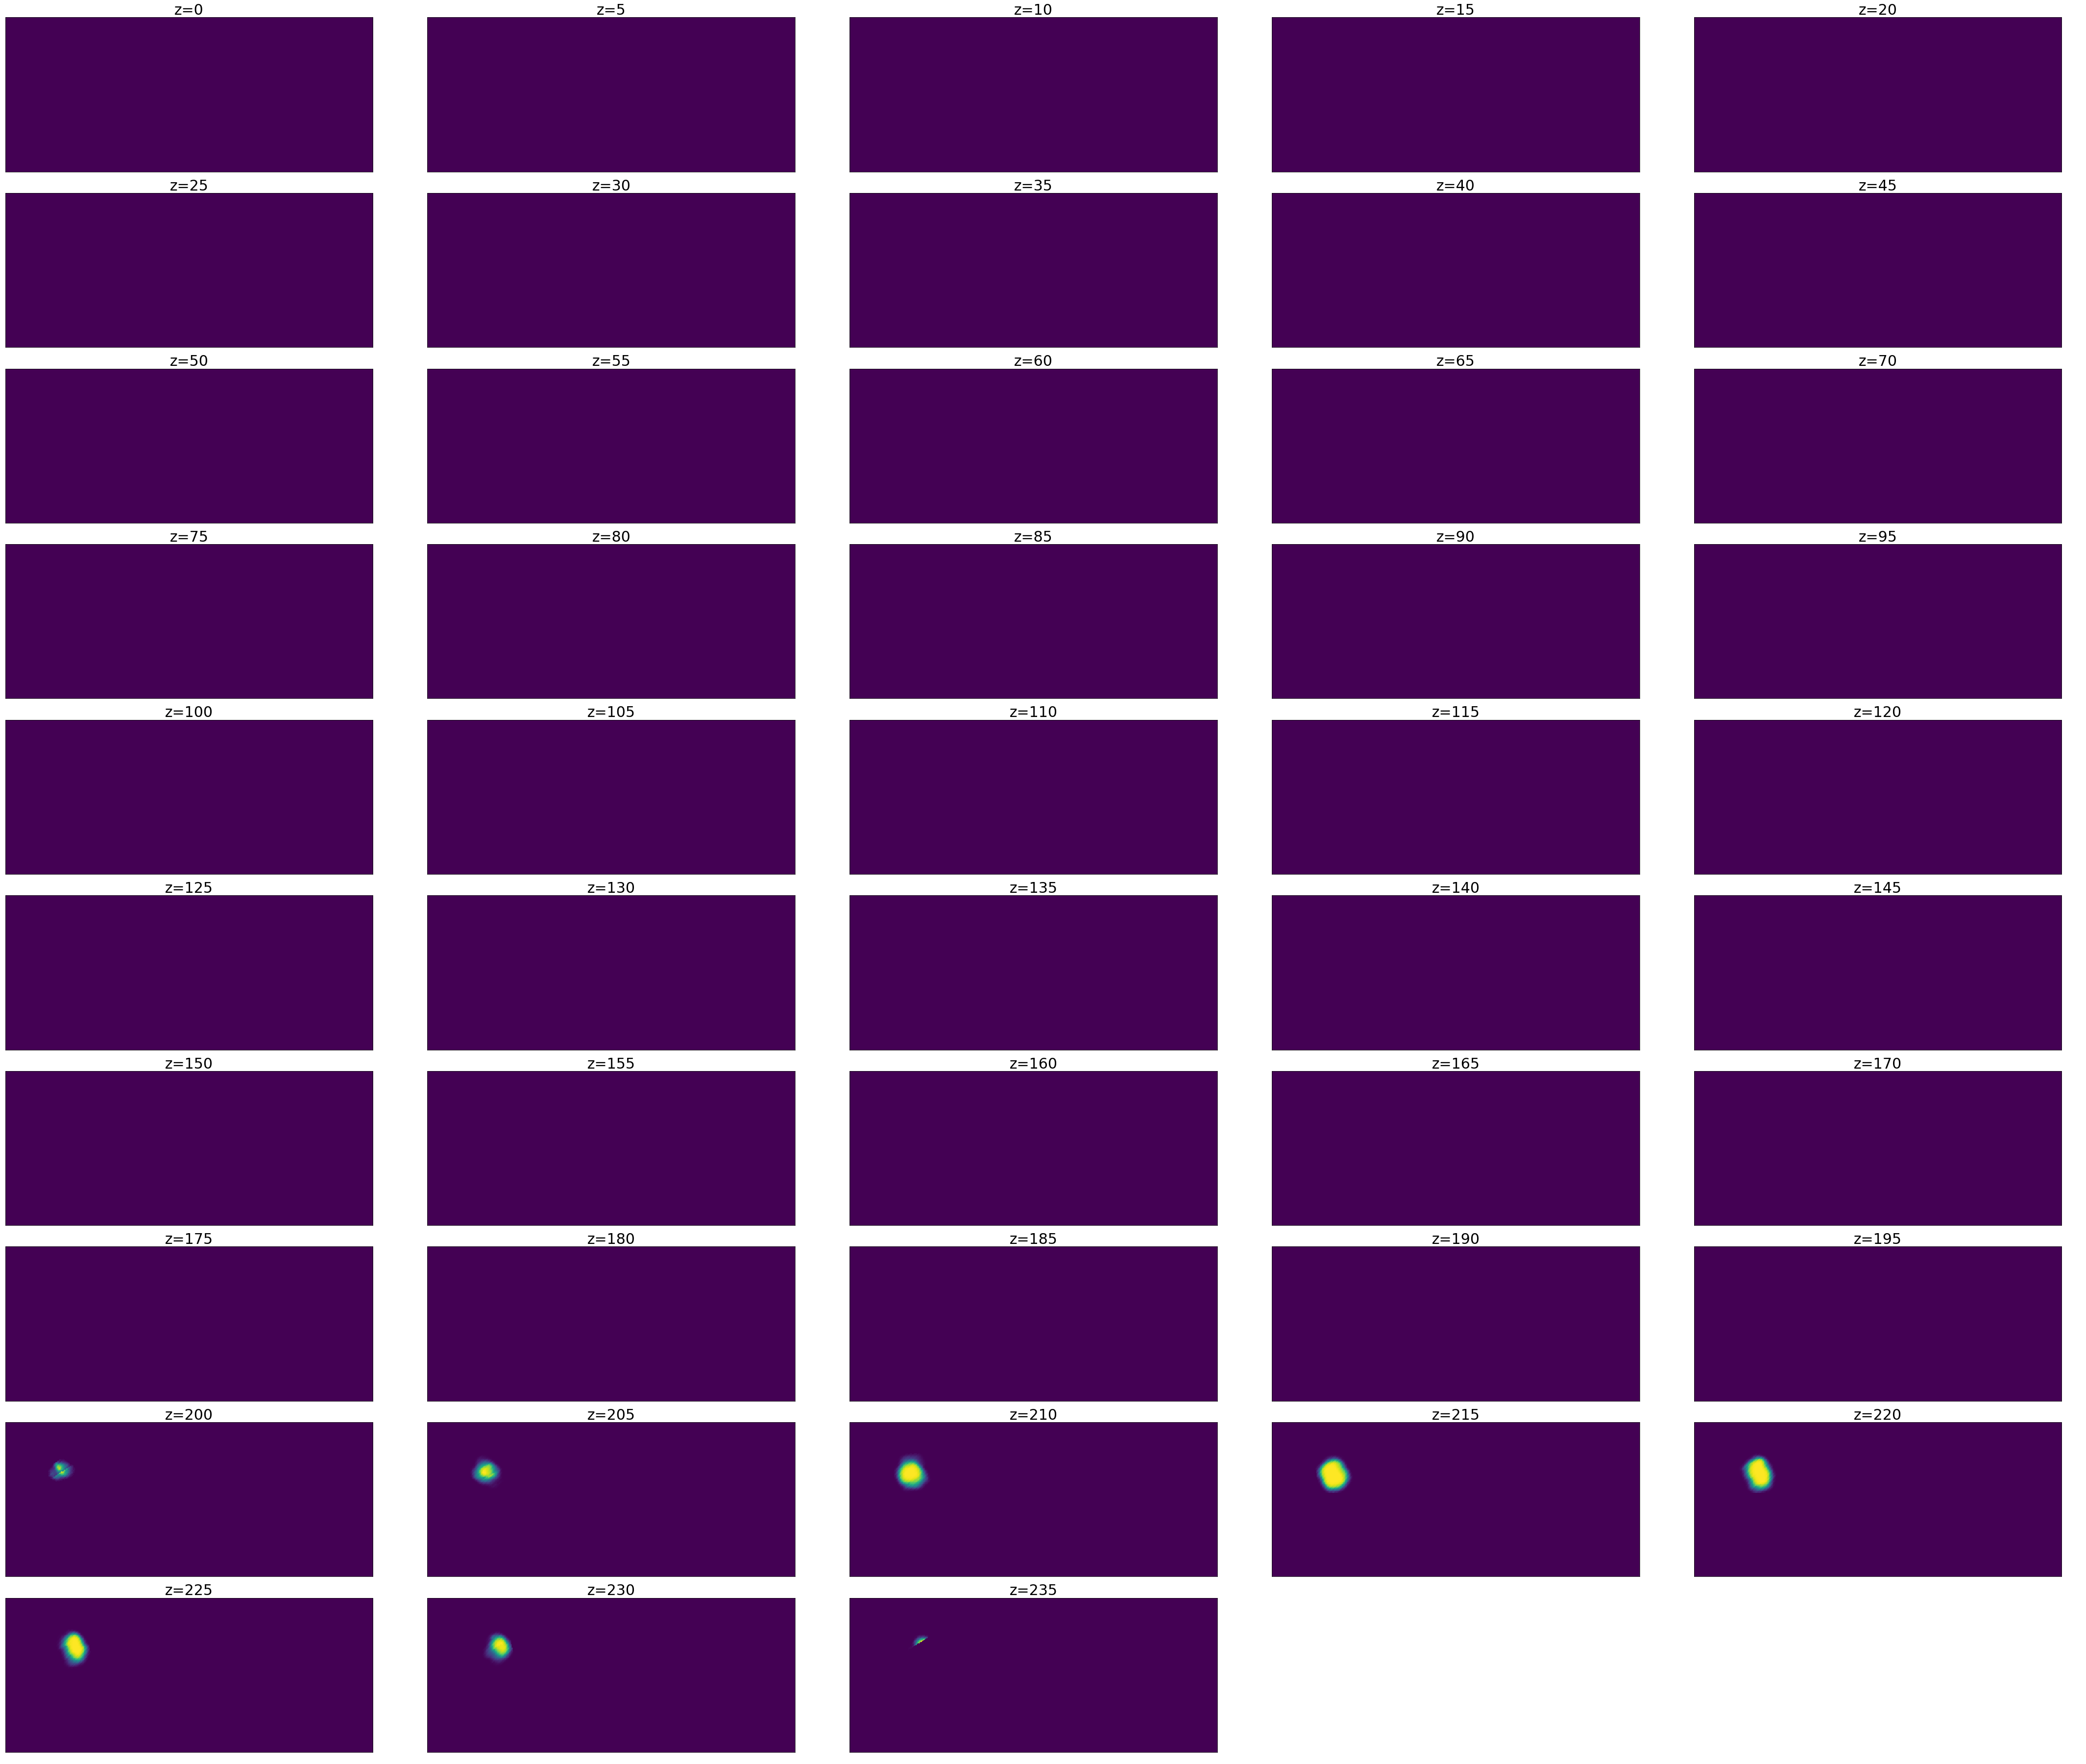

In [189]:
display_volume_sections(crop_and_pad_volume(volume_m_alignedTo_f, in_bbox=volume_m_alignedTo_f_bbox,
                                           out_bbox=(0, xdim_f-1, 0, ydim_f-1, 0, zdim_f-1)), 
                        start_level=0)